In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [4]:
train_ext = pd.read_csv('../../data/games/train_ext.csv')  
print(train_ext.shape)

train_ext.drop(columns=['author_id'], inplace=True)

(140495, 18)


In [5]:
# missing = train_ext.isna().sum().sort_values(ascending=False)
# plt.figure(figsize=(6,4))
# sns.barplot(x=missing.values, y=missing.index, palette="magma")
# plt.title('miss by cols')
# plt.tight_layout()

Text(0.5, 1.0, 'class balans')

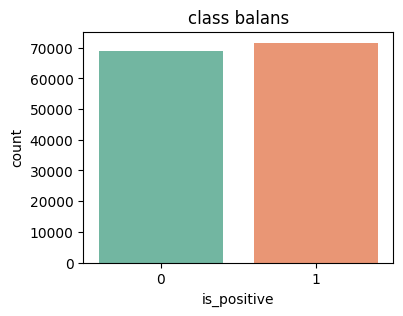

In [6]:
plt.figure(figsize=(4,3))
sns.countplot(x='is_positive', data=train_ext, palette='Set2')
plt.title("class balans")

419580


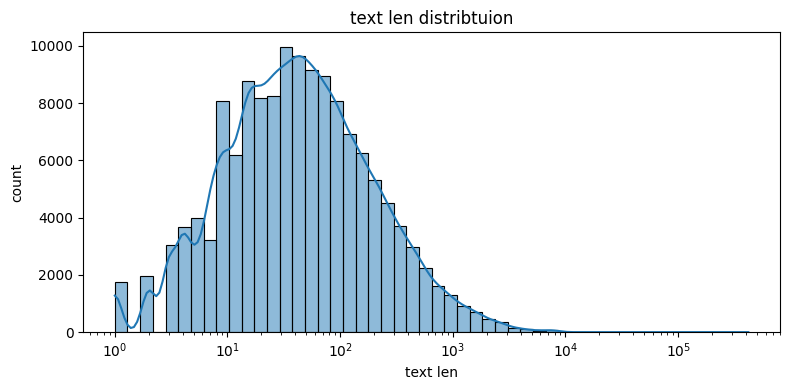

In [7]:
train_ext['text_len'] = train_ext['content'].str.len()
print(train_ext['text_len'].max())

plt.figure(figsize=(8,4))
sns.histplot(train_ext['text_len'], bins=50, kde=True, log_scale=(True, False))
plt.title('text len distribtuion')
plt.xlabel('text len')
plt.ylabel('count')
plt.tight_layout()
plt.show()

0


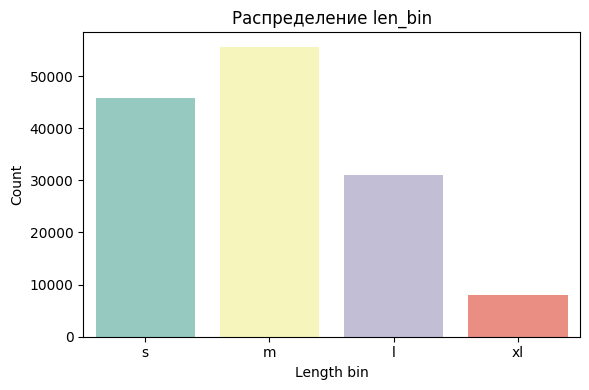

In [8]:
print(train_ext['text_len'].isna().sum())
train_ext['log_text_len'] = np.log1p(train_ext['text_len'])

bins = [0,20,100,500,np.inf]
labels = ['s', 'm', 'l', 'xl']
train_ext['len_bin'] = pd.cut(
    train_ext['text_len'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

train_ext = train_ext.drop(columns=['text_len'])
train_ext['len_bin'] = train_ext['len_bin'].astype('category')

plt.figure(figsize=(6,4))
sns.countplot(x='len_bin', data=train_ext, palette='Set3')
plt.title("Распределение len_bin")
plt.xlabel("Length bin")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

**Numeric analysis**

In [9]:
num_feats = [
    'price_final', 'discount_percent', 'recommendations',
    'review_score', 'positive', 'negative',
    'steamspy_positive', 'steamspy_negative',
    'release_year', 'log_text_len'
]

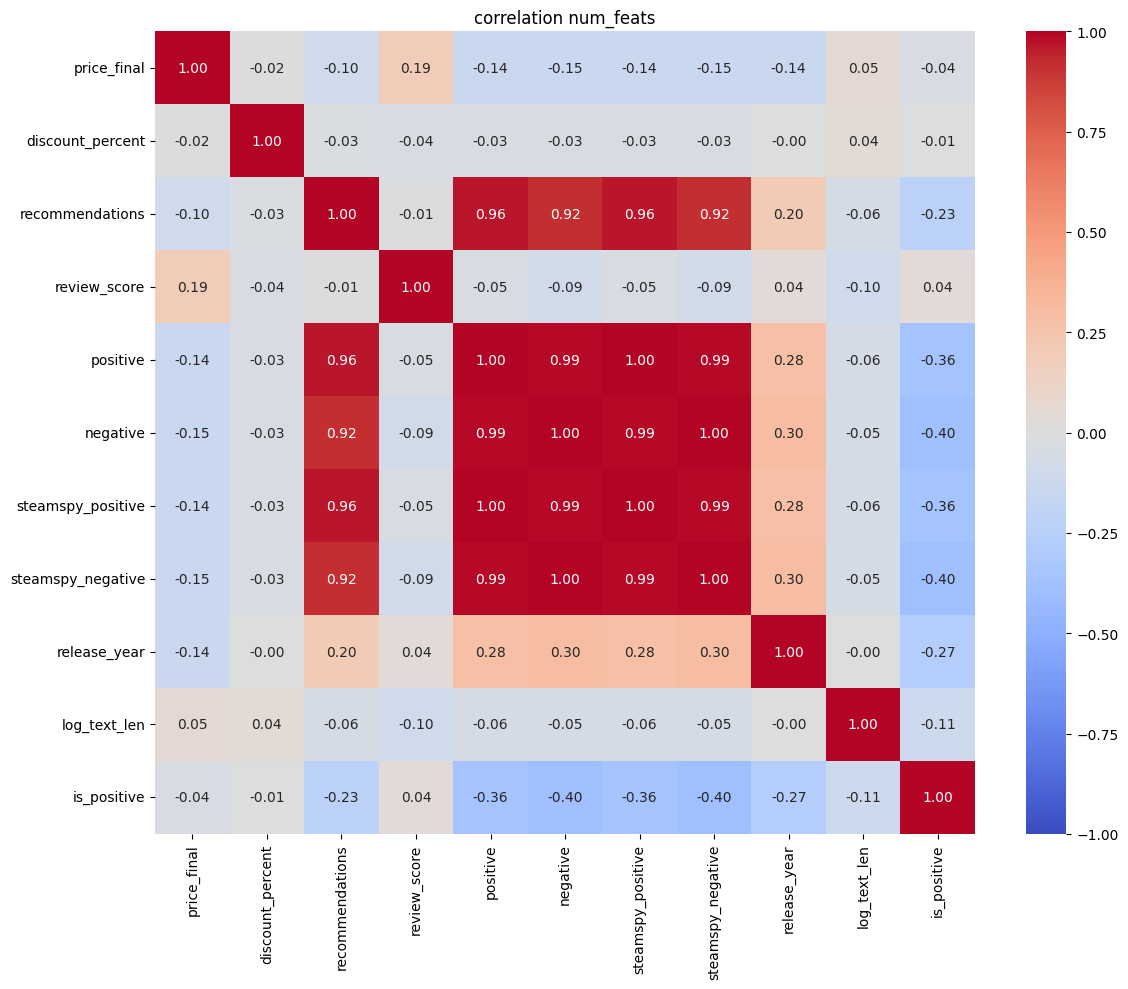

In [10]:
corr = train_ext[num_feats + ['is_positive']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("correlation num_feats")
plt.tight_layout()
plt.show()

можно выкинуть price_final, discount_percent, review_score, log_text_len (они не помогают различить is_positive)

In [11]:
train_ext = train_ext.drop(columns=['price_final'])
train_ext = train_ext.drop(columns=['review_score'])
train_ext = train_ext.drop(columns=['discount_percent'])
train_ext = train_ext.drop(columns=['log_text_len'])


recommendations, positive, negative, steamspi_positive, steamspy_negative – мультиколлинеарные. Можно сделать: pos_ratio = positive / total + reccomendations

In [12]:
train_ext['total'] = train_ext['positive'] + train_ext['negative']
train_ext['pos_ratio'] = train_ext['positive'] / train_ext['total']
train_ext = train_ext.drop(columns=['positive',
                                    'negative', 'steamspy_positive',
                                    'steamspy_negative'])




corr pos_ratio - is_positive: 0.25


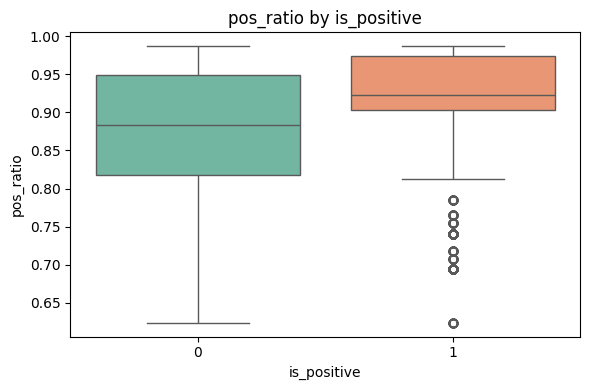

In [13]:
corr_val = train_ext['pos_ratio'].corr(train_ext['is_positive'])
print(f"corr pos_ratio - is_positive: {corr_val:.2f}")
plt.figure(figsize=(6,4))
sns.boxplot(x='is_positive', y='pos_ratio', data=train_ext, palette='Set2')
plt.title("pos_ratio by is_positive")
plt.tight_layout()
plt.show()

видно что медиана для is_positive=1  выше, чем у is_positive=0

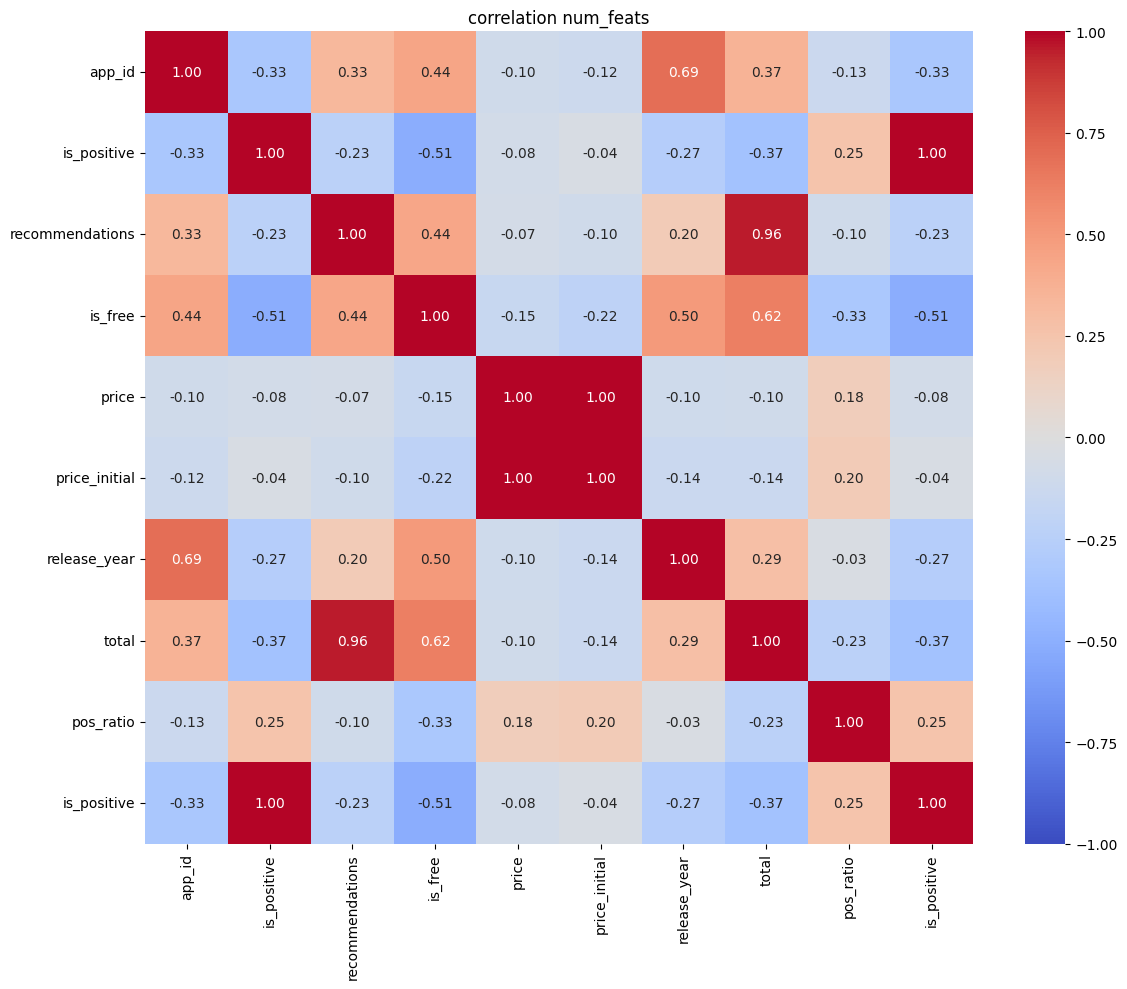

In [14]:
num_feats = train_ext.select_dtypes(include=[np.number]).columns.tolist()
corr = train_ext[num_feats + ['is_positive']].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("correlation num_feats")
plt.tight_layout()
plt.show()

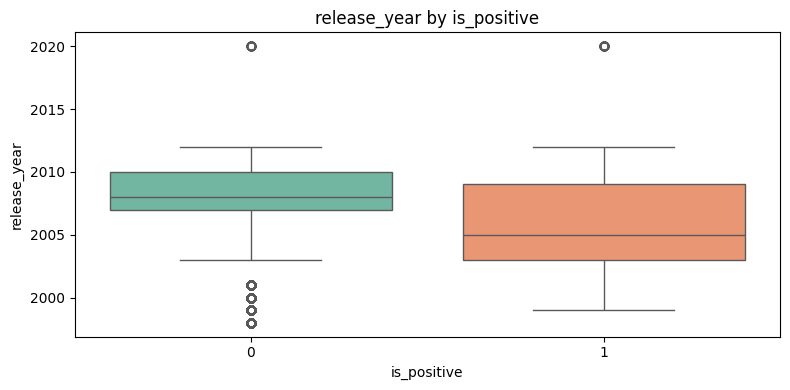

In [15]:
plt.figure(figsize=(8,4))
sns.boxplot(x='is_positive', y='release_year', data=train_ext, palette='Set2')
plt.title("release_year by is_positive")
plt.xlabel("is_positive")
plt.ylabel("release_year")
plt.tight_layout()
plt.show()

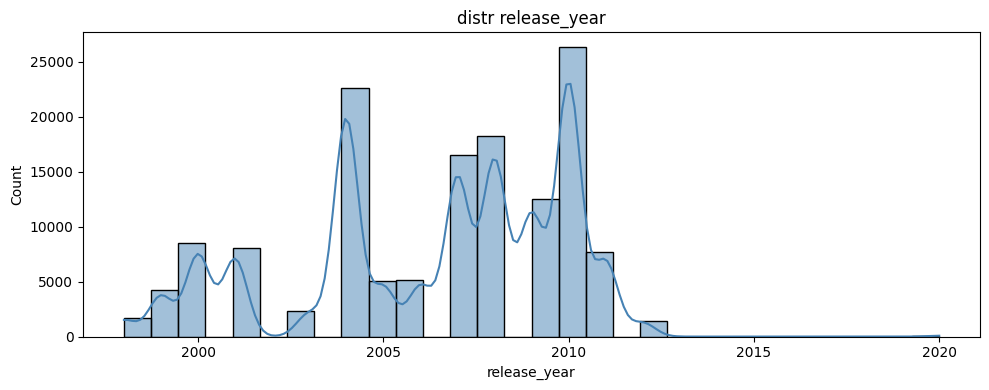

In [16]:
plt.figure(figsize=(10,4))
sns.histplot(train_ext['release_year'], bins=30, kde=True, color='steelblue')
plt.title("distr release_year")
plt.xlabel("release_year")
plt.tight_layout()
plt.show()

Что-то не так с release_year

In [17]:
labels = ['early','mid-era','recent','latest']
train_ext['year_bin'] = pd.qcut(
    train_ext['release_year'],
    q=4,
    labels=labels
)

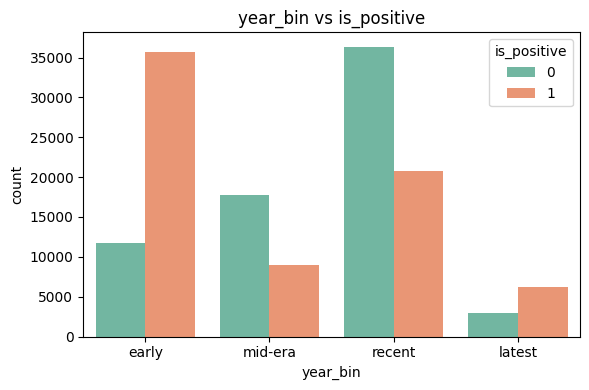

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x='year_bin', hue='is_positive', data=train_ext, palette='Set2')
plt.title("year_bin vs is_positive")
plt.tight_layout()
plt.show()

уберем release_year, оставим year_bin

In [19]:
train_ext = train_ext.drop(columns=['release_year'])
train_ext['year_bin'] = train_ext['year_bin'].astype('category')

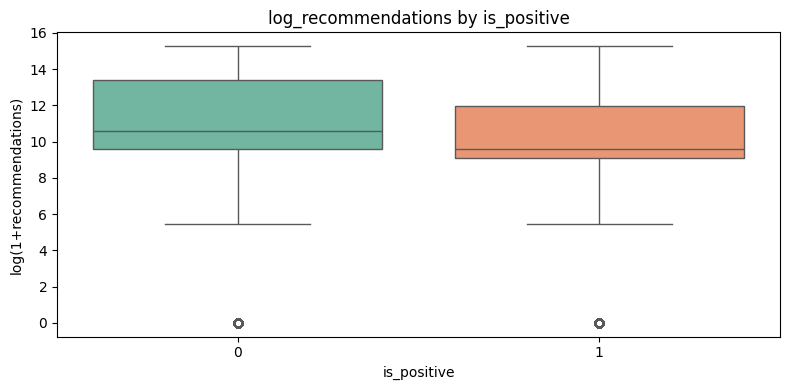

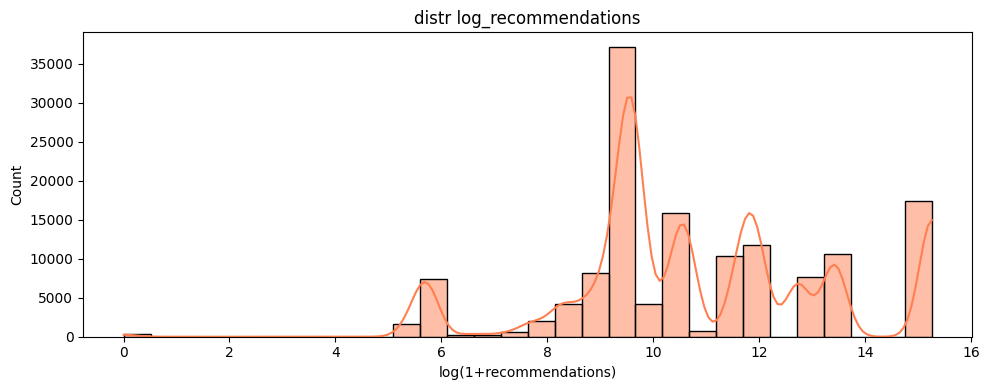

In [20]:
train_ext['log_recommendations'] = np.log1p(train_ext['recommendations'])

plt.figure(figsize=(8,4))
sns.boxplot(x='is_positive', y='log_recommendations', data=train_ext, palette='Set2')
plt.title("log_recommendations by is_positive")
plt.xlabel("is_positive")
plt.ylabel("log(1+recommendations)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(train_ext['log_recommendations'], bins=30, kde=True, color='coral')
plt.title("distr log_recommendations")
plt.xlabel("log(1+recommendations)")
plt.tight_layout()
plt.show()

In [21]:
corr_rec   = train_ext['recommendations'].corr(train_ext['is_positive'])
corr_logr  = train_ext['log_recommendations'].corr(train_ext['is_positive'])
print(f"corr rec: {corr_rec:.2f}, corr log_rec: {corr_logr:.2f}")

corr rec: -0.23, corr log_rec: -0.21


оставим log_rec

In [22]:
train_ext = train_ext.drop(columns=['recommendations'])

-------

is_positive,0,1
len_bin,,
s,0.433532,0.566468
m,0.478509,0.521491
l,0.561843,0.438157
xl,0.613665,0.386335


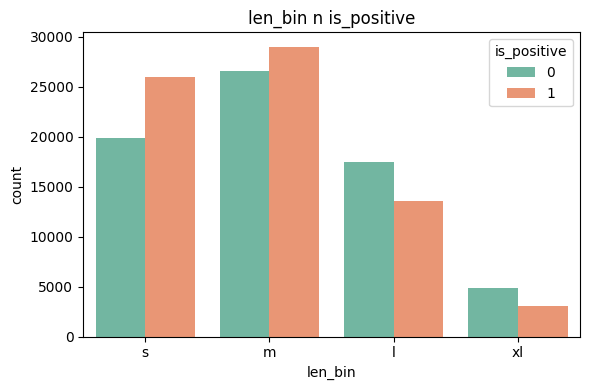

is_positive,0,1
year_bin,,
early,0.247011,0.752989
mid-era,0.666206,0.333794
recent,0.636322,0.363678
latest,0.321219,0.678781


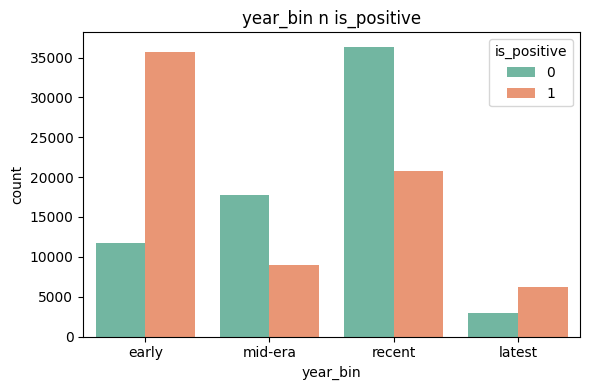

In [23]:
for cat in ['len_bin','year_bin']:
    
    ct = pd.crosstab(train_ext[cat], train_ext['is_positive'], normalize='index')
    display(ct)

    
    plt.figure(figsize=(6,4))
    sns.countplot(x=cat, hue='is_positive', data=train_ext, palette='Set2')
    plt.title(f"{cat} n is_positive")
    plt.tight_layout()
    plt.show()

year_bin, len_bin оставляем. Они помогают различить is_positive

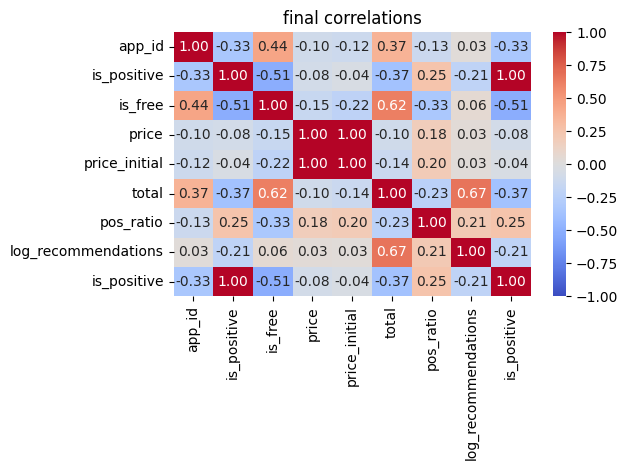

In [24]:
num_feats = train_ext.select_dtypes(include=[np.number]).columns.tolist()
corr = train_ext[num_feats + ['is_positive']].corr()
plt.figure()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("final correlations")
plt.tight_layout()
plt.show()

уберем price, total, app_id

In [25]:
train_ext = train_ext.drop(columns=['app_id', 'price_initial', 'total'])

In [26]:
num_feats = ['pos_ratio', 'log_recommendations', 'price', 'is_free']
cat_feats = ['len_bin', 'year_bin']
targ = 'is_positive'


In [27]:
train_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140495 entries, 0 to 140494
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   content              140495 non-null  object  
 1   is_positive          140495 non-null  int64   
 2   name                 140495 non-null  object  
 3   is_free              140495 non-null  int64   
 4   price                140495 non-null  float64 
 5   currency             140495 non-null  object  
 6   len_bin              140495 non-null  category
 7   pos_ratio            140495 non-null  float64 
 8   year_bin             140495 non-null  category
 9   log_recommendations  140495 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 8.8+ MB


In [26]:
drop_cols = ['content', 'name', 'currency']
X = train_ext.drop(columns=[targ] + drop_cols)
y = train_ext[targ]

In [27]:
train_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140495 entries, 0 to 140494
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   content              140495 non-null  object  
 1   is_positive          140495 non-null  int64   
 2   name                 140495 non-null  object  
 3   is_free              140495 non-null  int64   
 4   price                140495 non-null  float64 
 5   currency             140495 non-null  object  
 6   len_bin              140495 non-null  category
 7   pos_ratio            140495 non-null  float64 
 8   year_bin             140495 non-null  category
 9   log_recommendations  140495 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 8.8+ MB


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.compose     import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_train, X_val, y_train, y_val = train_test_split(
    X,y,test_size=.2,random_state=42,stratify=y
)

pp = ColumnTransformer([
    ('num', StandardScaler(),   num_feats),
    ('cat', OneHotEncoder(drop='first'), cat_feats)
])

clf = Pipeline([
    ('pp', pp),
    ('model', LogisticRegression())
])

clf.fit(X_train, y_train)
print('val roc auc:', roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))


val roc auc: 0.834872612068633


In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {'model__C':[0.01,0.1,1,10], 'model__class_weight':[None,'balanced']}
gs = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_params_, gs.best_score_)

{'model__C': 0.1, 'model__class_weight': None} 0.838091820318408


In [30]:
from sklearn.metrics import roc_auc_score

pp = ColumnTransformer([
    ('num', StandardScaler(),   num_feats),
    ('cat', OneHotEncoder(drop='first'), cat_feats)
])

clf = Pipeline([
    ('pp', pp),
    ('model', LogisticRegression())
])
clf.set_params(model__C=10, model__class_weight=None)

clf.fit(X_train, y_train)
print('val roc auc:', roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))


val roc auc: 0.8348734635265144


LOG_REGRESSION - .83855

In [28]:
drop_cols = ['name', 'currency']
X = train_ext.drop(columns=[targ] + drop_cols)
y = train_ext[targ]
X_train, X_val, y_train, y_val = train_test_split(
    X,y,test_size=.2,random_state=42,stratify=y
)


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
pp = ColumnTransformer([
    ('num',   StandardScaler(),           num_feats),
    ('cat',   OneHotEncoder(drop='first'),cat_feats),
    ('tfidf', TfidfVectorizer(
                  max_features=5000,
                  ngram_range=(3,5),
                  analyzer='char_wb',
                  stop_words='english'),
              'content')
])
clf = Pipeline([
    ('preproc', pp),
    ('model',    LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)
print('val roc auc:', roc_auc_score(y_val, clf.predict_proba(X_val)[:,1]))

joblib.dump(clf, '../../logreg_tfidf_pipeline.joblib')

val roc auc: 0.9408336768053609


['../../logreg_tfidf_pipeline.joblib']

TFID = 0.9385

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# собираем пайплайн с XGBoost
clf_xgb = Pipeline([
    ('preproc', pp),
    ('model',   XGBClassifier(
                    # use_label_encoder=True,  # ← удалили
                    eval_metric='auc',
                    verbosity=0,
                    random_state=42))
])

# # сетка гиперпараметров
# param_grid_xgb = {
#     'model__n_estimators': [100, 300],
#     'model__max_depth':    [4, 6, 8],
#     'model__learning_rate':[0.01, 0.1],
#     'model__subsample':    [0.7, 1.0],
#     'model__colsample_bytree':[0.7, 1.0]
# }

# gs_xgb = GridSearchCV(
#     clf_xgb,
#     param_grid_xgb,
#     cv=5,
#     scoring='roc_auc',
#     n_jobs=-1
# )

# gs_xgb.fit(X_train, y_train)
# print("XGB best params:", gs_xgb.best_params_)
# print("XGB CV AUC:",    gs_xgb.best_score_)

In [ ]:
from catboost import CatBoostClassifier
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.model_selection import RandomizedSearchCV

# 1. Собираем пайплайн с OD early stopping
clf_cb = Pipeline([
    ('preproc', pp),
    ('model', CatBoostClassifier(
        eval_metric='AUC',
        random_seed=42,
        logging_level='Silent',
        od_type='Iter',    # internal early stopping
        od_wait=30
    ))
])

# 2. RandomizedSearch без передачи eval_set
with tqdm_joblib(tqdm(total=20, desc='CatBoost Search')):
    rs_cb = RandomizedSearchCV(
        clf_cb,
        param_distributions=param_dist_cb,
        n_iter=20,
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2,
        random_state=42
    )
    rs_cb.fit(X_train, y_train)

print("Best params CatBoost:", rs_cb.best_params_)
print("CV AUC CatBoost:",    rs_cb.best_score_)

# 3. Финальное дообучение (можно без eval_set)
best_cb = rs_cb.best_estimator_
best_cb.fit(X_train, y_train)
print("val roc auc CatBoost:", roc_auc_score(y_val, best_cb.predict_proba(X_val)[:,1]))
joblib.dump(best_cb, '../../catboost_tfidf_pipeline.joblib')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=4, model__n_estimators=500, model__subsample=0.7; total time= 1.6min
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=4, model__n_estimators=500, model__subsample=0.7; total time= 1.7min
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=4, model__n_estimators=500, model__subsample=1.0; total time= 1.7min
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=4, model__n_estimators=500, model__subsample=1.0; total time= 1.7min
[CV] END model__colsample_bytree=1.0, model__learning_rate=0.05, model__max_depth=4, model__n_estimators=500, model__subsample=1.0; total time= 1.7min
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=4, model__n_estimators=500, model__subsample=0.7; total time= 1.9min
[CV] END model__colsample_bytree=

In [ ]:
best_params = rs_xgb.best_params_
clf_xgb.set_params(**best_params)
clf_xgb.fit(X_train, y_train)

print('val roc auc:', roc_auc_score(y_val, clf_xgb.predict_proba(X_val)[:,1]))

import joblib
joblib.dump(clf_xgb, '../../xgb_tfidf_pipeline.joblib')

val roc auc: 0.9627789647168219


['../../xgb_tfidf_pipeline.joblib']

XGB_TFIDF = 0.96

In [37]:
from catboost import CatBoostClassifier
from tqdm_joblib import tqdm_joblib
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.compose     import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score



num_feats = ['pos_ratio', 'log_recommendations', 'price', 'is_free']
cat_feats = ['len_bin', 'year_bin']
targ = 'is_positive'

pp = ColumnTransformer([
    ('num',   StandardScaler(),           num_feats),
    ('cat',   OneHotEncoder(drop='first'),cat_feats),
    ('tfidf', TfidfVectorizer(
                  max_features=5000,
                  ngram_range=(3,5),
                  analyzer='char_wb',
                  stop_words='english'),
              'content')
])
clf_cb = Pipeline([
    ('preproc', pp),
    ('model', CatBoostClassifier(
        eval_metric='AUC',
        random_seed=42,
        od_type='Iter', 
        od_wait=30,
        thread_count=4,
    ))
])
# param_dist_cb = {
#     'model__iterations':      [100, 300, 500],
#     'model__depth':           [4, 6, 8],
#     'model__learning_rate':   [0.01, 0.05, 0.1],
#     'model__l2_leaf_reg':     [1, 3, 5, 7],
#     'model__subsample':       [0.7, 1.0]
# }

clf_cb.set_params(
    model__verbose=10,              
    model__iterations=300,
    model__depth=6,
    model__learning_rate=0.05,
    model__l2_leaf_reg=3,
    model__subsample=0.8
)

# rs_cb = RandomizedSearchCV(
#     clf_cb,
#     param_distributions=param_dist_cb,
#     n_iter=10,
#     cv=3,
#     scoring='roc_auc',
#     n_jobs=2,
#     verbose=2,
#     random_state=42
# )

# with tqdm_joblib(tqdm(total=10, desc='CatBoost RS')):
#     rs_cb.fit(X_train, y_train)

clf_cb.fit(X_train, y_train)
print("val roc auc cb:",
      roc_auc_score(y_val, clf_cb.predict_proba(X_val)[:,1]))


joblib.dump(clf_cb, '../../catboost_tfidf_pipeline.joblib')

0:	total: 1.41s	remaining: 7m
10:	total: 18.7s	remaining: 8m 10s
20:	total: 34.3s	remaining: 7m 35s
30:	total: 48.7s	remaining: 7m 2s
40:	total: 1m 1s	remaining: 6m 30s
50:	total: 1m 16s	remaining: 6m 14s
60:	total: 1m 30s	remaining: 5m 52s
70:	total: 1m 44s	remaining: 5m 36s
80:	total: 1m 57s	remaining: 5m 17s
90:	total: 2m 12s	remaining: 5m 3s
100:	total: 2m 27s	remaining: 4m 50s
110:	total: 2m 41s	remaining: 4m 35s
120:	total: 2m 54s	remaining: 4m 18s
130:	total: 3m 7s	remaining: 4m 1s
140:	total: 3m 19s	remaining: 3m 44s
150:	total: 3m 31s	remaining: 3m 28s
160:	total: 3m 43s	remaining: 3m 13s
170:	total: 3m 55s	remaining: 2m 57s
180:	total: 4m 7s	remaining: 2m 42s
190:	total: 4m 18s	remaining: 2m 27s
200:	total: 4m 30s	remaining: 2m 13s
210:	total: 4m 42s	remaining: 1m 59s
220:	total: 4m 53s	remaining: 1m 44s
230:	total: 5m 5s	remaining: 1m 31s
240:	total: 5m 17s	remaining: 1m 17s
250:	total: 5m 29s	remaining: 1m 4s
260:	total: 5m 42s	remaining: 51.1s
270:	total: 5m 54s	remaining:

['../../catboost_tfidf_pipeline.joblib']